<h1>Building the OCR</h1>

<h3>Taking text detection input in text recognition</h3>

In [1]:
from keras.models import Model, load_model,  model_from_json
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from skimage.transform import rescale, resize, downscale_local_mean
import text_detect as t
import numpy as np

C:\Users\Aquib\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#loading the text recognition model and their respective weights
textrecog_model = load_model('textrecog/text_recog_1.m')
textrecog_model.load_weights('textrecog/text_recog_1.weights')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\Aquib\Anaconda3\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
json_file = open('textdetect/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
textdetect_model = model_from_json(loaded_model_json, custom_objects={'tf': tf, 'RESIZE_FACTOR': 2})
textdetect_model.load_weights('textdetect/model.weights')

In [4]:
# For Image Enhancement removing noise 
''''
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
blur = cv2.blur(img,(5,5))
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
ret,thresh2 = cv2.threshold(th3,127,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh2[200:350,1000:1700],cmap='gray')'''

"'\nimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   \nblur = cv2.blur(img,(5,5))\nth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,            cv2.THRESH_BINARY,11,2)\nret,thresh2 = cv2.threshold(th3,127,255,cv2.THRESH_BINARY_INV)\nplt.imshow(thresh2[200:350,1000:1700],cmap='gray')"

In [5]:
 #reading and converting to RGB
imag = cv2.imread("image/img (29).jpg")[:, :, ::-1]

In [6]:
# Resizing image 
imag_resized, (ratio_h, ratio_w) = t.resize_image(imag)
imag_resized = (imag_resized / 127.5) - 1

In [7]:
# Adding new axis and predicting the score_map and geo_map in a image 
# Predicting with Model 1 Text Detection
score_map, geo_map = textdetect_model.predict(imag_resized[np.newaxis, :, :, :])

In [8]:
# Detecting boxes by score_map and geo_map
boxes= t.detect(score_map=score_map, geo_map=geo_map)

1904 text boxes before nms


In [9]:
# Getting the cropped images by dividing to original image
if boxes is not None:
    boxes = boxes[:, :8].reshape((-1, 4, 2))
    boxes[:, :, 0] /= ratio_w
    boxes[:, :, 1] /= ratio_h

In [10]:
# Total 73 text box detected 
len(boxes)

73

In [11]:
# Detected images by 4 rows and 2 column in array
boxes[3]

array([[698.6028, 431.1772],
       [781.1517, 424.4136],
       [782.4027, 439.6511],
       [699.8537, 446.4145]], dtype=float32)

In [12]:
lio = []
for i in range(0,len(boxes)):
    pts = boxes[i] # assign Each 8 points to pts
    rect = cv2.boundingRect(pts) # Creating a rectangle by 8 points
    x,y,w,h = rect 
    croped = imag[y:y+h, x:x+w].copy()
    lio.append(croped) # appending every images to a list

In [13]:
# cropped images in a array form
lio[1]

array([[[ 96,  80,  83],
        [105,  82,  88],
        [ 98,  86,  88],
        ...,
        [255, 254, 255],
        [255, 254, 255],
        [255, 255, 255]],

       [[ 96,  80,  83],
        [101,  80,  85],
        [101,  91,  92],
        ...,
        [255, 255, 255],
        [255, 255, 253],
        [255, 255, 253]],

       [[107,  88,  92],
        [101,  80,  85],
        [ 98,  89,  90],
        ...,
        [255, 255, 253],
        [255, 255, 253],
        [255, 255, 253]],

       ...,

       [[255, 255, 255],
        [249, 249, 249],
        [222, 224, 221],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [253, 253, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[254, 254, 254],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [253, 253, 253],
        [253, 253, 253]]

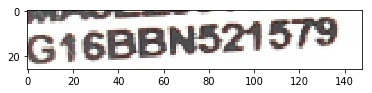

In [14]:
# This is how every cropped images will look like
plt.imshow(lio[1])

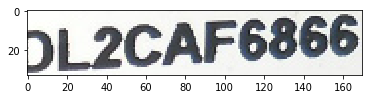

In [15]:
plt.imshow(lio[0])

In [16]:
# Total 73 boxes 
len(lio)

73

In [17]:
# Converting each image to a grayscale
gray = []
for i in range(0,len(boxes)):
    img = cv2.cvtColor(lio[i], cv2.COLOR_BGR2GRAY)
    gray.append(img)

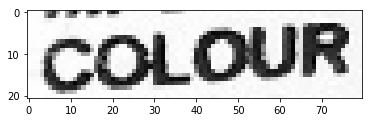

In [18]:
plt.imshow(gray[44],cmap='gray')

In [19]:
gray[0].shape

(33, 170)

In [20]:
lp=[]
for i in range(0,len(boxes)):
    
    # convert each image of shape (32, 128, 1)
    w, h = gray[i].shape
    
    # converting each cropped images to input size
    if h > 128 or w > 32:
        gray[i] = cv2.resize(gray[i], (128,32)) 
        w,h = gray[i].shape
    
    if w < 32:
        add_zeros = np.ones((32-w, h))*255
        gray[i] = np.concatenate((gray[i], add_zeros))

    if h < 128:
        add_zeros = np.ones((32, 128-h))*255
        gray[i] = np.concatenate((gray[i], add_zeros), axis=1)
    gray[i] = np.expand_dims(gray[i] , axis = 2)
    lp.append(gray[i])

In [21]:
# Normalize each image
for i in range(0,len(lp)):
    lp[i] = lp[i]/255
    lp = np.array(lp)

In [22]:
# using text recognition model to detect the text in all 73 boxes
# Predicting with Model 2 Text Recognition
pred = textrecog_model.predict(lp)

In [23]:
# Decoding the 72 boxes prediction by ctc layer
out = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],greedy=True)[0][0])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [29]:
alpa = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','0','1','2','3','4','5','6','7','8','9']

In [30]:
for x in out:
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            #  alpha[1] gives b decoding the outputs
            print(alpa[int(p)], end = '')       
    print('\n')

predicted text = JL2CAF6866

predicted text = G161BJEJN524379

predicted text = HNDM4ANSM1U0

predicted text = R8919H811N9

predicted text = REG11

predicted text = BEHNN1D0

predicted text = NL2AJMUJDDUN7

predicted text = MJA3EELJ91S00

predicted text = T0WAL7

predicted text = NFG0

predicted text = ADDRES51

predicted text = UJP700

predicted text = 02X0412021

predicted text = DELM1

predicted text = 18L48581

predicted text = K3M104812006

predicted text = M10000

predicted text = JAJNG1PUJRA1

predicted text = HP1LEASE3

predicted text = MFG1D7

predicted text = 8N0

predicted text = AU1tD01709

predicted text = M0DE4

predicted text = S19N41UJ18

predicted text = UNL4ADEN1

predicted text = SUBHAS1

predicted text = SEA71NG4

predicted text = MATH1UR44

predicted text = TAX

predicted text = N03

predicted text = CH1AJND0

predicted text = B4A58

predicted text = 4SM9

predicted text = WHEE4

predicted text = ELALEN01

predicted text = CU1CALP

predicted text = 0FCY1

predicted